## Analysis of COVID Pandemic in Mexico (2020-2022)

In this project, we analyzed the first four COVID-19 infected waves in Mexico, from the start up to the year where vaccines begin to be applied.

We considered the data provided by CONACYT during the contingency, from the 2022-02-26 to the 2022-05-22.

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

plt.rcParams['font.family'] = 'monospace';
pd.set_option('display.max_columns', 101);

%config InlineBackend.figure_format = 'retina'

<div style="font-size: 16px;">
We started by extracting and cleaning the data provided by <b>CONACYT</b> in a CSV file with the daily COVID-19 cases. This Database contains information about all Mexican states, however, the format is somewhat unusual as the cases are shown in rows. We first must do some rearrangements to the data set using Pandas.
</div>

#### Converting Data from CONACYT table into matrix

In [4]:
# READING DATA FILE
data = pd.read_table('Data/Casos_Diarios_Estado_Nacional_Confirmados_20220522.csv',sep=',');
data = data.transpose(); # Rows to colums

# First two rows contain the number of state and its population, third one is
# for the state names. We split population and infected values.
population = data[1:2];
population.columns = data.iloc[2];

data.columns = data.iloc[2];
data = data[3:]; # Removing First two rows

# DEFINING NEW DATA SET FOR THE CLEANING PROCESS
clean_data = data.copy();

display(population);
display(pd.DataFrame(clean_data['Nacional']).transpose());

nombre,AGUASCALIENTES,BAJA CALIFORNIA,BAJA CALIFORNIA SUR,CAMPECHE,CHIAPAS,CHIHUAHUA,DISTRITO FEDERAL,COAHUILA,COLIMA,DURANGO,GUANAJUATO,GUERRERO,HIDALGO,JALISCO,MEXICO,MICHOACAN,MORELOS,NAYARIT,NUEVO LEON,OAXACA,PUEBLA,QUERETARO,QUINTANA ROO,SAN LUIS POTOSI,SINALOA,SONORA,TABASCO,TAMAULIPAS,TLAXCALA,VERACRUZ,YUCATAN,ZACATECAS,Nacional
poblacion,1434635,3634868,804708,1000617,5730367,3801487,9018645,3218720,785153,1868996,6228175,3657048,3086414,8409693,17427790,4825401,2044058,1288571,5610153,4143593,6604451,2279637,1723259,2866142,3156674,3074745,2572287,3650602,1380011,8539862,2259098,1666426,127792286


,26-02-2020,27-02-2020,28-02-2020,29-02-2020,01-03-2020,02-03-2020,03-03-2020,04-03-2020,05-03-2020,06-03-2020,07-03-2020,08-03-2020,09-03-2020,10-03-2020,11-03-2020,12-03-2020,13-03-2020,14-03-2020,15-03-2020,16-03-2020,17-03-2020,18-03-2020,19-03-2020,20-03-2020,21-03-2020,22-03-2020,23-03-2020,24-03-2020,25-03-2020,26-03-2020,27-03-2020,28-03-2020,29-03-2020,30-03-2020,31-03-2020,01-04-2020,02-04-2020,03-04-2020,04-04-2020,05-04-2020,06-04-2020,07-04-2020,08-04-2020,09-04-2020,10-04-2020,11-04-2020,12-04-2020,13-04-2020,14-04-2020,15-04-2020,...,03-04-2022,04-04-2022,05-04-2022,06-04-2022,07-04-2022,08-04-2022,09-04-2022,10-04-2022,11-04-2022,12-04-2022,13-04-2022,14-04-2022,15-04-2022,16-04-2022,17-04-2022,18-04-2022,19-04-2022,20-04-2022,21-04-2022,22-04-2022,23-04-2022,24-04-2022,25-04-2022,26-04-2022,27-04-2022,28-04-2022,29-04-2022,30-04-2022,01-05-2022,02-05-2022,03-05-2022,04-05-2022,05-05-2022,06-05-2022,07-05-2022,08-05-2022,09-05-2022,10-05-2022,11-05-2022,12-05-2022,13-05-2022,14-05-2022,15-05-2022,16-05-2022,17-05-2022,18-05-2022,19-05-2022,20-05-2022,21-05-2022,22-05-2022
Nacional,0,4,2,2,2,5,9,10,11,6,7,8,5,17,39,41,66,52,37,77,104,116,151,132,85,70,168,220,185,224,262,191,166,345,311,382,347,392,250,259,631,515,581,483,572,464,479,953,936,985,...,275,986,783,789,749,684,294,249,769,659,629,255,178,156,182,832,550,702,531,514,235,260,788,640,619,568,475,177,167,762,710,692,613,667,231,213,967,418,1060,920,907,347,291,1252,1179,1245,1191,797,135,1


#### Cleaning Data (Removing anomalies and smoothing)

<div style="font-size: 16px;">

Cleaning data is a process dependent on the data itself, we must understand what are we working with before designing strategies to get more reliable values. During the pandemic, the daily infected cases were reported by many hospitals and medical institutions. This data was processed by CONACYT to increase its accuracy. Due to the nature of data collection, days such as weekends and holidays report lower cases, possibly caused by hospitals not fully operating. As a consequence of this, we have many gaps in the infected waves that can be obstacles to the use of models and the overall work.

Acknowledging the problems of the recollection, we can propose a straightforward yet simple way of substituting these "anomalies", this is by identifying and replacing them with an average of the neighboring values. We can divide the whole process into three stages:

<ol type="I" style="font-space:2px;">
<li style="padding-bottom:10px">
<b>ANOMALY CRITERIA:</b> Starting from an initial average of the data, we must give a tolerance factor that once multiplied by this average can be able to segregate anomalies from desired values, this has to be manually tweaked. After finding an anomaly, we replace its value with the average of the 6 surrounding neighbors, we choose this number to make it weekly averaged.
</li>
<li style="padding-bottom:10px">
<b>FINAL SMOOTHING:</b> Once the data is cleaned, we can average the values two more times to reduce the fluctuations and smooth even more the data, while keeping the reliability.
</li>
<li style="padding-bottom:10px">
<b>DERIVATIVE FOR COMPARISON:</b> Showing a curve that appears to be clean does not offer much information about the advantages of using raw quantities. Since many of the models we will be working with rely on the derivative of the data, we can see both the fluctuations of each data set and if we can use it to apply our models. Instead of applying the derivative to consecutive days, we set a window of 3 days, equivalent to half-week to reduce the noise of the raw data.
</li>
</ol>

</div>

In [16]:
def data_cleaner(data,case_name,delta,smoothness,window):
    clean_data = data[case_name].copy();
    derivative_data = [];
    derivative_clean = [];

    # Accepted Data and Anomaly Data SPLIT
    normal_wave = []; normal_wave.append(0);
    anomaly_wave = []; anomaly_wave.append(0);
    normal_time = []; normal_time.append(0);
    anomaly_time = []; anomaly_time.append(0);

    # Delta criteria (tweak manually to obtain a better fit)
    # Average
    average_data =[];
    average_time = [];

    # (i) CRITERIA TO REMOVE ANOMALIES
    for i in range(1,len(data[case_name])):

        if (i>=3 and i<=len(data[case_name])-3):
            # Initial average to get anomalie criteria
            average_data.append((sum(data[case_name][i-3:i])+sum(data[case_name][i+1:i+4]))/6);
            average_time.append(i);
            k = delta*average_data[-1];

        if (i>=3):
            # Anomalie criteria
            if (data[case_name][i]<k):
                anomaly_wave.append(data[case_name][i]);
                anomaly_time.append(i);
                clean_data[i] = (sum(data[case_name][i-3:i])+sum(data[case_name][i+1:i+4]))/6;
            else:
                normal_wave.append(data[case_name][i]);
                normal_time.append(i);

    # (ii) FINAL TWEAKS TO SMOOTH DATA
    # Smoothing Data
    for i in range(smoothness):
        # 3 to complete a week (2*3 + 1 = 7)
        for ii in range(3,len(clean_data)-3):
            clean_data[ii] = (sum(clean_data[ii-3:ii])+sum(clean_data[ii+1:ii+4]))/6;

    # (iii) COMPARISON BETWEEN RAW AND FINAL DATA
    # Derivative
    for i in range(window,len(clean_data)):
        derivative_clean.append(((clean_data[i])-(clean_data[i-window]))/(window));
        derivative_data.append(((data[case_name][i])-(data[case_name][i-window]))/(window));

    return clean_data, derivative_clean, derivative_data, anomaly_wave, anomaly_time, normal_wave, normal_time

In [ ]:
national_clean, national_derivative, data_derivative,aw,at,nw,nt = data_cleaner(data,'Nacional',0.8,2,3);
national_clean.to_csv('data/CleanedData.csv');

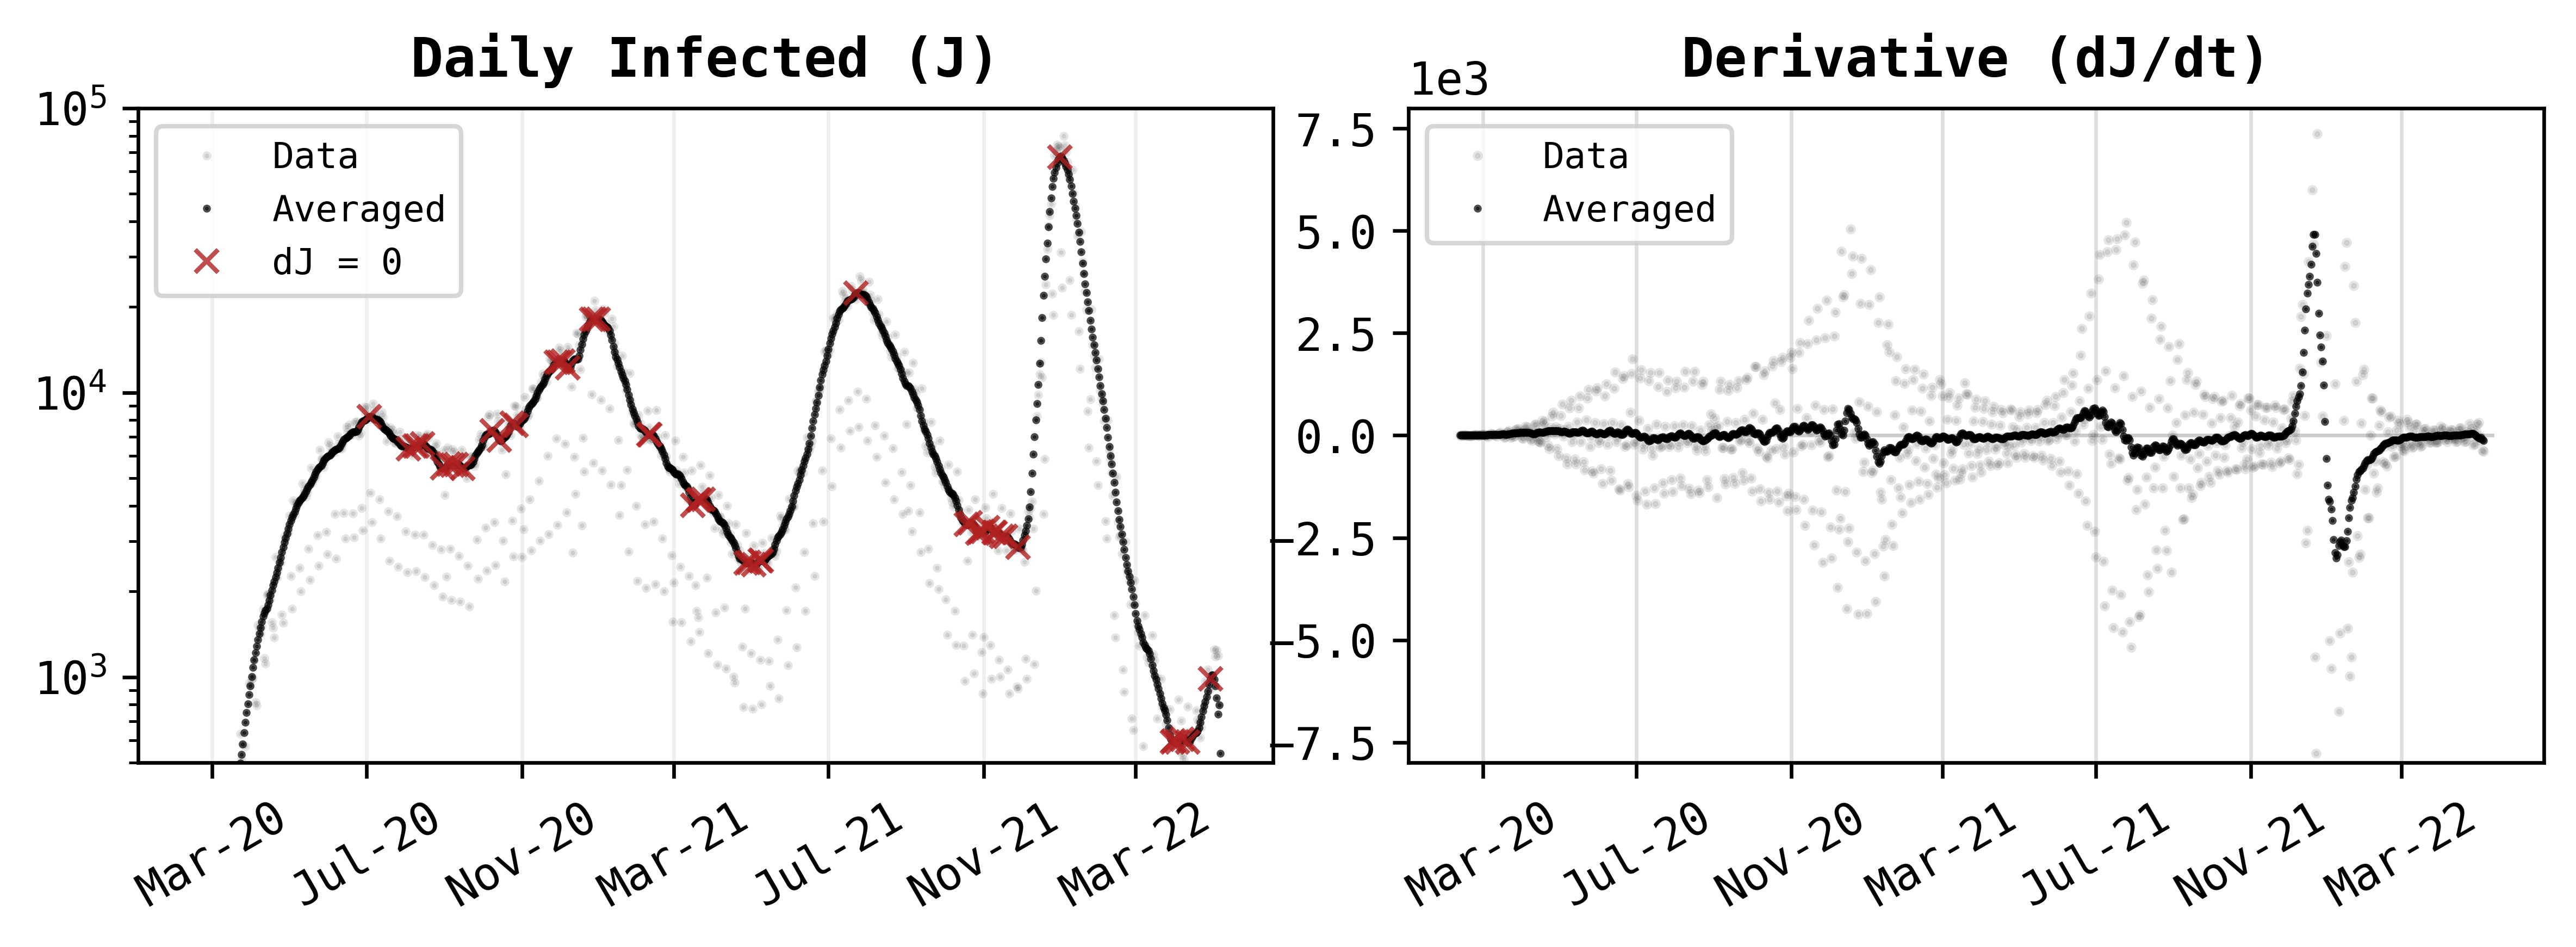

In [ ]:
# FINDING ZERO DERIVATIVE POINTS
zero_derivative = [];
for i in range(1,len(national_derivative)):
    if (national_derivative[i]*national_derivative[i-1]<0):
        zero_derivative.append(i);

# CREATING X-LABELS
dates = [datetime.strptime(k,'%d-%m-%Y').date() for k in list(national_clean.index)];
x_times = [];
x_labels = [];
for i in range(len(data)):
    if dates[i].day==15 and ((dates[i].month+1)%4)==0: x_labels.append(dates[i].strftime('%b')+"-"+dates[i].strftime('%y')); x_times.append(i);

first_fig, axs = plt.subplots(1,2,figsize=(8,3),dpi=300);

axs[0].plot(data["Nacional"].to_list(),'.',c='k',ms=2,alpha=0.1);
axs[0].plot(national_clean,'.',c='k',alpha=0.7,lw=0.8,ms=1.5);
axs[0].plot(zero_derivative,[national_clean[k] for k in zero_derivative],'x',c='firebrick',alpha=0.8,lw=0.8,ms=5,);
axs[0].set_yscale('log');
axs[0].set_ylim([5*10**2,10**5]);
axs[0].set_xticks(x_times,x_labels,fontsize=10,rotation=30);

axs[0].legend(['Data','Averaged','dJ = 0'],fontsize=8,loc='upper left');
axs[0].set_title('Daily Infected (J)',fontweight='bold',pad=7);
axs[0].grid(axis='x',linestyle='-',alpha=0.2);

window = 3;
axs[1].grid(axis='x',linestyle='-',alpha=0.4);
axs[1].plot(data_derivative,'.',c='k',ms=2.5,alpha=0.1)
axs[1].plot(range(0,len(national_clean)-window),national_derivative,'.',c='k',ms=1.5,alpha=0.7);

axs[1].plot([0,820],[0,0],'-',c='k',lw=0.8,alpha=0.2);
axs[1].set_ylim([-8*10**3,8*10**3]); axs[1].ticklabel_format(style='sci',axis='y',scilimits=(0,0));

axs[1].legend(['Data','Averaged'],fontsize=8);
axs[1].set_title('Derivative (dJ/dt)',fontweight='bold',pad=7);
axs[1].set_xticks(x_times,x_labels,fontsize=10,rotation=30);

plt.tight_layout();
plt.savefig("images/DataCleaning.png",dpi=300);

<div style="font-size: 14px;">
<b>Figure 1.</b> Comparison between data before and after the cleaning process.
<div>

<div style="font-size: 16px;">
It is possible to obtain cleaned values maintaining their key characteristics. The derivative is a good indicator of the adequate approach to the cleaning and we can even get some results from it by identifying the stationary points (where its value is zero), highlighting the days where we can encounter the wave peaks or the valleys. This is shown as red crosses in the daily infected. While it is possible to remark some valleys, some stationary points are the result of small fluctuations and, therefore, it remains necessary to manually select the useful values.
<div>


In [19]:
# DAYS OF ZERO DERIVATIVE
display(pd.concat([pd.DataFrame(np.copy(zero_derivative)).transpose(),\
                   pd.DataFrame([dates[k] for k in zero_derivative]).transpose()]));

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,142,173,178,180,184,200,205,208,211,216,239,245,255,258,290,292,295,299,318,320,323,363,364,398,402,403,406,440,442,446,451,452,527,614,617,623,625,627,631,636,637,642,645,655,688,777,778,781,785,789,807
0,2020-07-17,2020-08-17,2020-08-22,2020-08-24,2020-08-28,2020-09-13,2020-09-18,2020-09-21,2020-09-24,2020-09-29,2020-10-22,2020-10-28,2020-11-07,2020-11-10,2020-12-12,2020-12-14,2020-12-17,2020-12-21,2021-01-09,2021-01-11,2021-01-14,2021-02-23,2021-02-24,2021-03-30,2021-04-03,2021-04-04,2021-04-07,2021-05-11,2021-05-13,2021-05-17,2021-05-22,2021-05-23,2021-08-06,2021-11-01,2021-11-04,2021-11-10,2021-11-12,2021-11-14,2021-11-18,2021-11-23,2021-11-24,2021-11-29,2021-12-02,2021-12-12,2022-01-14,2022-04-13,2022-04-14,2022-04-17,2022-04-21,2022-04-25,2022-05-13


<div style="font-size: 16px;">
Just to conclude this Notebook, we first need to split data into waves that we can properly study through epidemic model fittings. For that matter, we have to exclude valleys as this adds noise to the fitting process. Model fits do love Gaussian-like waves, so we should select time ranges that include both growth and decay behavior. Later we can discuss other state cases with anomalous wave dynamics or lower data.
</div>

<div style="font-size: 16px;">
Besides infections, during this pandemic, many people lost their lives and, to get a complete picture of the whole pandemic phenomenon, I include this data as well. This is stored in a different CSV file provided by CONACYT. Values included range starting from 17-03-2020, meaning there is a shift of 20 days. This data does not present the same decrease in values on weekends. So we will just smooth the data a little.
</div>

In [20]:
deaths = pd.read_table('Data/Casos_Diarios_Estado_Nacional_Defunciones_20221023.csv',sep=',');
deaths = deaths.transpose(); # Rows to colums
deaths.columns = deaths.iloc[2];
deaths = deaths[3:]; # Removing First two rows

number_smothness = 2;
for i in range(number_smothness):
    # 3 to complete a week (2*3 + 1 = 7)
    for ii in range(3,len(deaths['Nacional'])-3):
        deaths['Nacional'][ii] = (sum(deaths['Nacional'][ii-3:ii])+sum(deaths['Nacional'][ii+1:ii+4]))/6;


shift = (datetime.strptime(deaths.index[0],'%d-%m-%Y') - datetime.strptime(clean_data.index[0],'%d-%m-%Y')).days;
deaths.to_csv('data/CleanedDefunctions.csv')

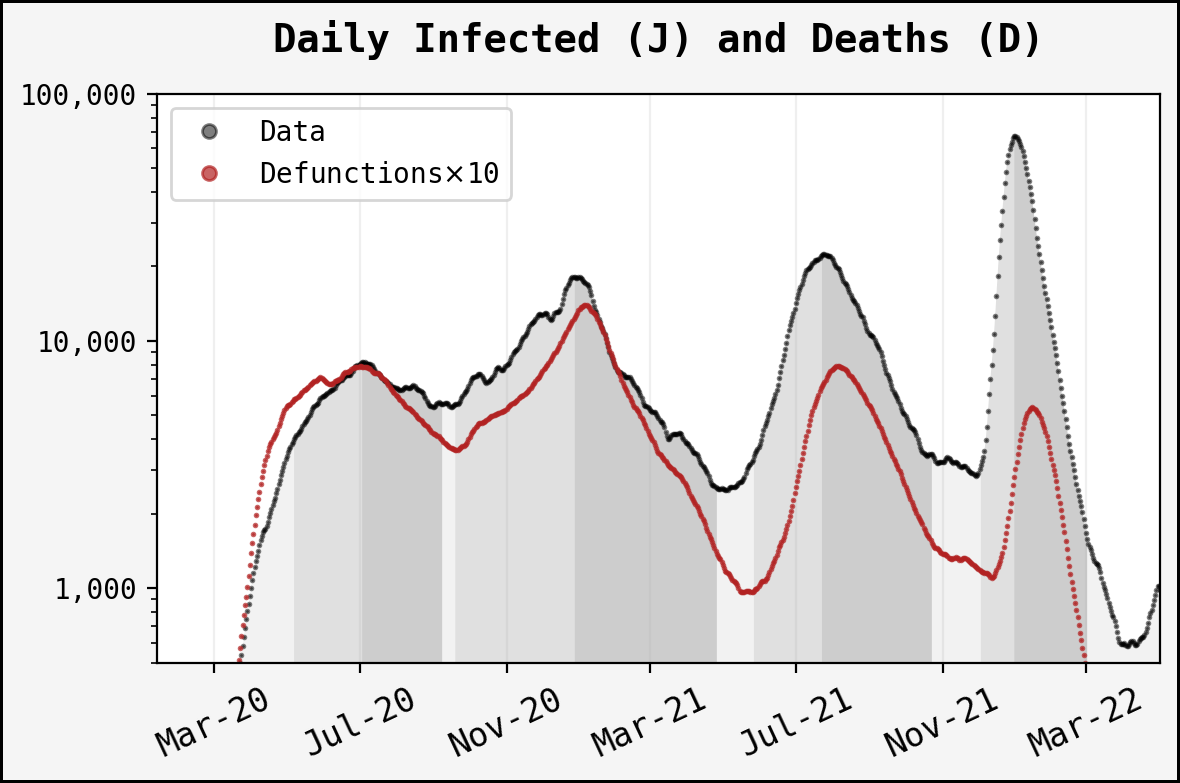

In [ ]:
waves_t0 = np.array([85,  220, 470, 660]);
peaks_t  = np.array([142, 320, 527, 688]);
waves_tf = np.array([210, 440, 620, 750]);
wave_time = {};
increase = {};
decrease = {};
fill_colors = ['#f8f8f8','#e5e5e5'];

first_fig, axs = plt.subplots(1,1,figsize=(6,4),facecolor='#f5f5f5',linewidth=1.5,edgecolor='k');

axs.fill_between(range(len(national_clean.to_list())),national_clean.to_list(),color='k',\
                 edgecolor='none',alpha=0.05,label='_nolegend_');

for i in range(len(waves_t0)):
    wave_time[i] = np.arange(waves_t0[i],waves_tf[i]);
    increase[i] = np.arange(waves_t0[i],peaks_t[i]+1);
    decrease[i] = np.arange(peaks_t[i],waves_tf[i]);
    axs.fill_between(increase[i],national_clean[waves_t0[i]:peaks_t[i]+1].to_list(),color='k',\
                     edgecolor='none',alpha=0.07,label='_nolegend_');
    axs.fill_between(decrease[i],national_clean[peaks_t[i]:waves_tf[i]].to_list(),color='k',\
                     edgecolor='none',alpha=0.15,label='_nolegend_');

axs.plot([],'.',c='k',alpha=0.5,lw=0.8,ms=10);
axs.plot([],'.',c='firebrick',alpha=0.7,lw=0.8,ms=10);
axs.plot(national_clean,'.',c='k',alpha=0.5,lw=0.8,ms=2,label='_nolegend_');
axs.plot(range((shift-1),len(deaths['Nacional'])+(shift-1)),10*deaths['Nacional'],'.',c='firebrick',alpha=0.7,ms=2,label='_nolegend_');
axs.set_yscale('log');
axs.set_ylim([5*10**2,10**5]);
axs.set_xlim([-30,810]);
axs.set_xticks(x_times,x_labels,fontsize=12,rotation=25);
axs.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
axs.set_title('Daily Infected (J) and Deaths (D)',fontweight='bold',pad=15,fontsize=14);

axs.legend(['Data',r'Defunctions$\times$10'],fontsize=10,loc='upper left');
axs.grid(axis='x',linestyle='-',alpha=0.2);

plt.tight_layout();
plt.savefig("images/PandemicMexico.png",dpi=300);

### Other State Cases

In [31]:
mexico_clean, mexico_derivative, dD,aw,at,nw,nt = data_cleaner(data,'MEXICO',0.8,2,3);

cdmx_clean, cdmx_derivative, dD,aw,at,nw,nt = data_cleaner(data,'DISTRITO FEDERAL',0.8,2,3);

jalisco_clean, jalisco_derivative, dD,aw,at,nw,nt = data_cleaner(data,'JALISCO',0.8,2,3);

veracruz_clean, veracruz_derivative, dD,aw,at,nw,nt = data_cleaner(data,'VERACRUZ',0.8,2,3);

puebla_clean, puebla_derivative, dD,aw,at,nw,nt = data_cleaner(data,'PUEBLA',0.8,2,3);

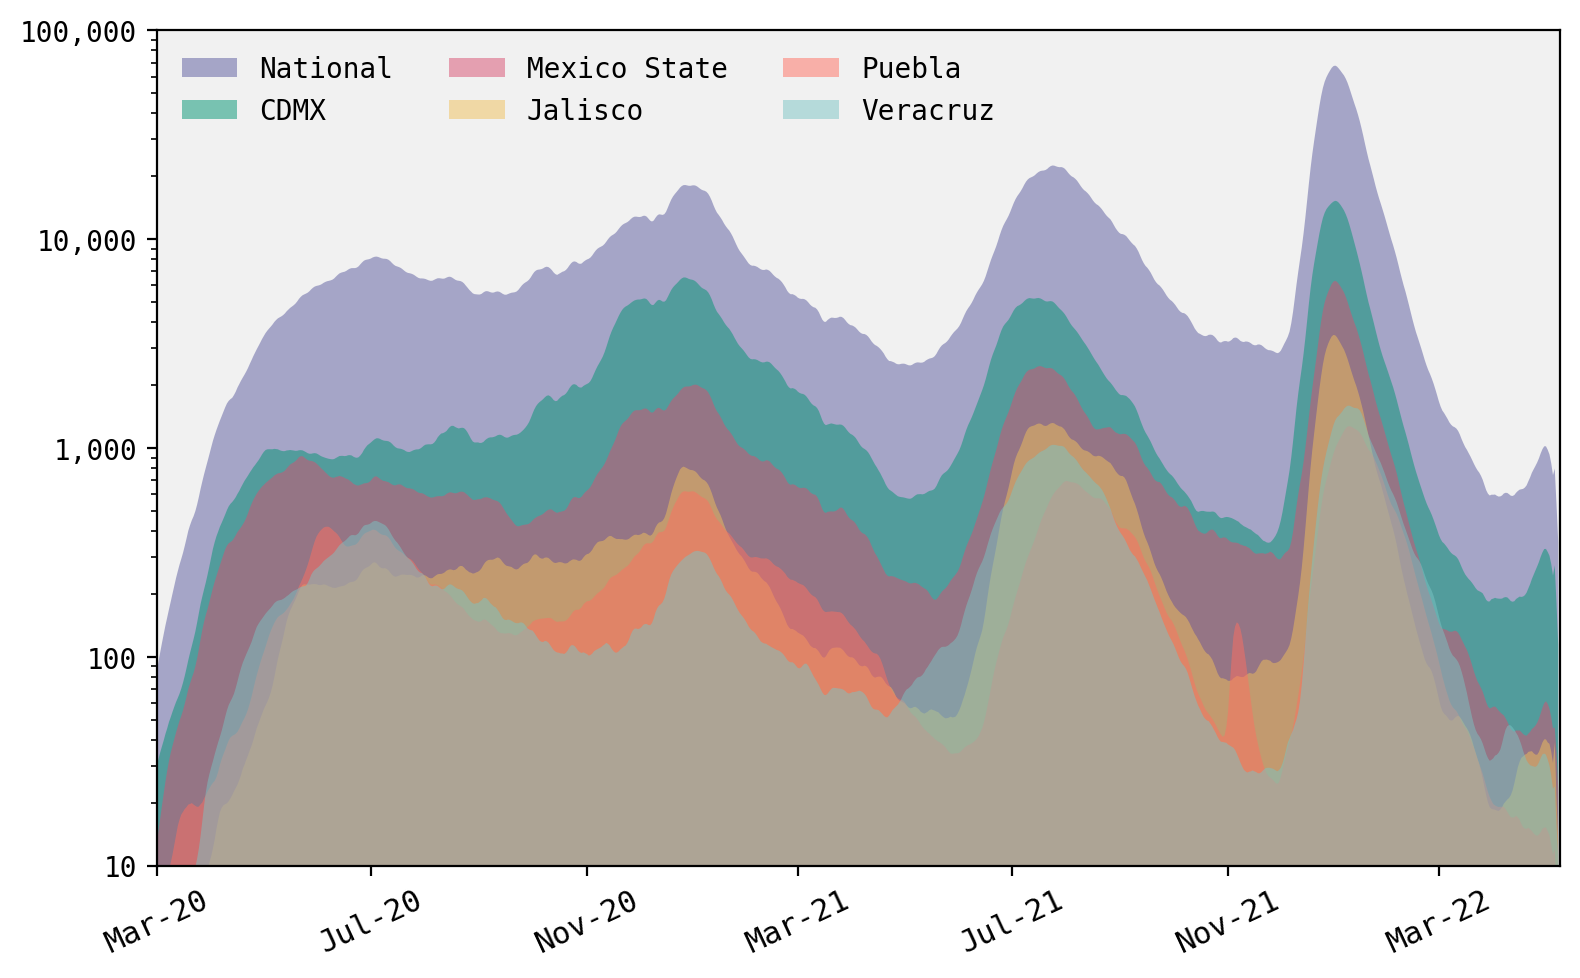

In [ ]:
colors = {0:'#5A5B9f',1:'#009473',2:'#D94f70',3:'#F0C05A',4:'#7BC4C4',5:'#FF6F61'};
x = range(len(clean_data['Nacional']));
fig,axs = plt.subplots(1,1,figsize=(8,5));
axs.set_facecolor('#f1f1f1');
plt.fill_between(x,national_clean.to_list(),'.',color=colors[0],edgecolor='none',alpha=0.5,label='National');
plt.fill_between(x,cdmx_clean.to_list(),'.',color=colors[1],edgecolor='none',alpha=0.5,label='CDMX');
plt.fill_between(x,mexico_clean.to_list(),'.',color=colors[2],edgecolor='none',alpha=0.5,label='Mexico State');
plt.fill_between(x,jalisco_clean.to_list(),'.',color=colors[3],edgecolor='none',alpha=0.5,label='Jalisco');
plt.fill_between(x,puebla_clean.to_list(),'.',color=colors[5],edgecolor='none',alpha=0.5,label='Puebla');
plt.fill_between(x,veracruz_clean.to_list(),'.',color=colors[4],edgecolor='none',alpha=0.5,label='Veracruz');
plt.yscale('log');
plt.ylim([10**1,10**5]);
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlim([40,len(clean_data['Nacional'])]);
plt.xticks(x_times,x_labels,fontsize=11,rotation=25);
plt.legend(loc='upper left',fontsize=10,frameon=False,ncols=3);
plt.tight_layout();

plt.savefig("images/PandemicMexicoStates.png",dpi=300);